**Chapter 16 – Reinforcement Learning**

This notebook contains all the sample code and solutions to the exersices in chapter 16.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Note: there may be minor differences between the output of this notebook and the examples shown in the book. You can safely ignore these differences. They are mainly due to the fact that most of the environments provided by OpenAI gym have some randomness.

# Introduction to OpenAI gym

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's start by importing `gym`:

In [2]:
import gym

Next we will load the MsPacman environment, version 0.

In [3]:
env = gym.make('Breakout-v0')
#BreakoutDeterministic-v4

Let's initialize the environment by calling is `reset()` method. This returns an observation:

In [4]:
obs = env.reset()

Observations vary depending on the environment. In this case it is an RGB image represented as a 3D NumPy array of shape [width, height, channels] (with 3 channels: Red, Green and Blue). In other environments it may return different objects, as we will see later.

In [5]:
obs.shape

(210, 160, 3)

An environment can be visualized by calling its `render()` method, and you can pick the rendering mode (the rendering options depend on the environment). In this example we will set `mode="rgb_array"` to get an image of the environment as a NumPy array:

In [6]:
img = env.render(mode="rgb_array")

Let's plot this image:

<IPython.core.display.Javascript object>


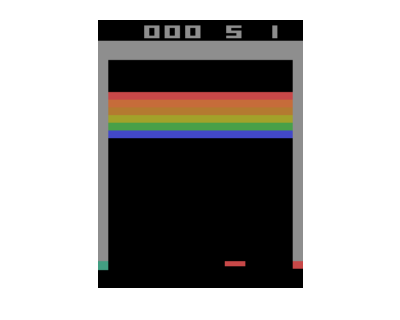

Saving figure BreakOut


In [7]:
plt.figure(figsize=(5,4))
plt.imshow(img)
plt.axis("off")
save_fig("BreakOut")
plt.show()

Welcome back to the 1980s! :)

In this environment, the rendered image is simply equal to the observation (but in many environments this is not the case):

In [8]:
(img == obs).all()

True

Let's create a little helper function to plot an environment:

In [9]:
def plot_environment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [10]:
env.action_space

Discrete(4)

In [11]:
env.unwrapped.get_keys_to_action()

{(): 0, (32,): 1, (97,): 3, (100,): 2}

In [12]:
 env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

 env.unwrapped.get_action_meanings()
['NOOP', 'FIRE', 'RIGHT', 'LEFT']

Next we need to tell the environment which action to play, and it will compute the next step of the game. Let's go left for 110 steps, then lower left for 40 steps:

In [13]:
env.reset()
for step in range(1100):
    env.step(1) #left
for step in range(1100):
    env.step(1) #lower-left

Where are we now?

<IPython.core.display.Javascript object>


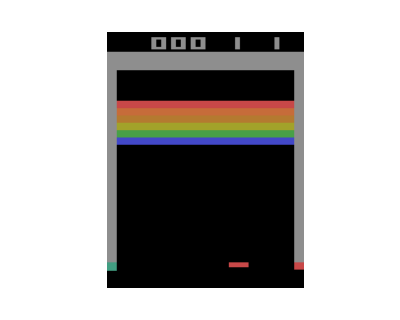

In [14]:
plot_environment(env)

The `step()` function actually returns several important objects:

In [15]:
obs, reward, done, info = env.step(0)

The observation tells the agent what the environment looks like, as discussed earlier. This is a 210x160 RGB image:

In [16]:
obs.shape

(210, 160, 3)

The environment also tells the agent how much reward it got during the last step:

In [17]:
reward

0.0

When the game is over, the environment returns `done=True`:

In [18]:
done

True

Finally, `info` is an environment-specific dictionary that can provide some extra information about the internal state of the environment. This is useful for debugging, but your agent should not use this information for learning (it would be cheating).

In [19]:
info

{'ale.lives': 0}

Let's play one full game (with 3 lives), by moving in random directions for 10 steps at a time, recording each frame:

In [20]:
frames = []

n_max_steps = 10000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode="rgb_array")
    #frames.append(img)
    if step % n_change_steps == 0:
        action = env.action_space.sample() # play randomly
    obs, reward, done, info = env.step(action)
    preprocessed_observations.append(preprocess_observation(obs))
    _obs = combine_observations_singlechannel(preprocessed_observations)
    frames.append(_obs)
    if done:
        break

NameError: name 'preprocessed_observations' is not defined

In [21]:
_obs.shape

NameError: name '_obs' is not defined

Now show the animation (it's a bit jittery within Jupyter):

In [22]:
import time

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40,name=""):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)
    
    timestr = time.strftime("%Y%m%d-%H%M%S")
    if name != "":
        anim.save('./animation_'+ name +"_"+ timestr + '.gif', dpi=80, writer='imagemagick')
    return anim

<IPython.core.display.Javascript object>


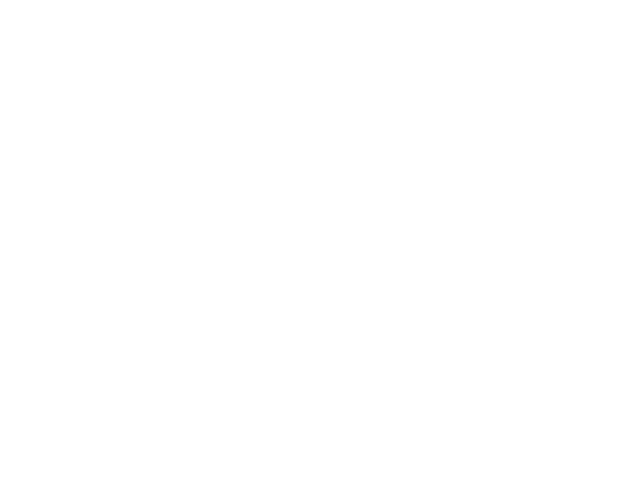

IndexError: list index out of range

In [23]:
video = plot_animation(frames)
plt.show()

Once you have finished playing with an environment, you should close it to free up resources:

In [24]:
env.close()

To code our first learning agent, we will be using a simpler environment: the Cart-Pole. 

# Learning to Play BreakOut Using the DQN Algorithm

**Warning**: Unfortunately, the first version of the book contained two important errors in this section.

1. The actor DQN and critic DQN should have been named _online DQN_ and _target DQN_ respectively. Actor-critic algorithms are a distinct class of algorithms.
2. The online DQN is the one that learns and is copied to the target DQN at regular intervals. The target DQN's only role is to estimate the next state's Q-Values for each possible action. This is needed to compute the target Q-Values for training the online DQN, as shown in this equation:

$y(s,a) = \text{r} + \gamma . \underset{a'}{\max} \, Q_\text{target}(s', a')$

* $y(s,a)$ is the target Q-Value to train the online DQN for the state-action pair $(s, a)$.
* $r$ is the reward actually collected after playing action $a$ in state $s$.
* $\gamma$ is the discount rate.
* $s'$ is the state actually reached after played action $a$ in state $s$.
* $a'$ is one of the possible actions in state $s'$.
* $Q_\text{target}(s', a')$ is the target DQN's estimate of the Q-Value of playing action $a'$ while in state $s'$.

I hope these errors did not affect you, and if they did, I sincerely apologize.

## Creating the Breakoutenvironment

In [25]:
import tensorflow as tf
#env = gym.make("Breakout-v0")
env = gym.make("BreakoutDeterministic-v4")

obs = env.reset()
obs.shape

/Users/gniemiec/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


(210, 160, 3)

In [26]:
env.action_space

Discrete(4)

## Preprocessing

Preprocessing the images is optional but greatly speeds up training.

In [27]:
def preprocess_observation(obs):
    img = obs[34:194:2, ::2] # crop and downsize
    return np.mean(img, axis=2).reshape(80, 80,1) / 255.0

img = preprocess_observation(obs)

In [28]:
img.shape

(80, 80, 1)

Note: the `preprocess_observation()` function is slightly different from the one in the book: instead of representing pixels as 64-bit floats from -1.0 to 1.0, it represents them as signed bytes (from -128 to 127). The benefit is that the replay memory will take up roughly 8 times less RAM (about 6.5 GB instead of 52 GB). The reduced precision has no visible impact on training.

<IPython.core.display.Javascript object>


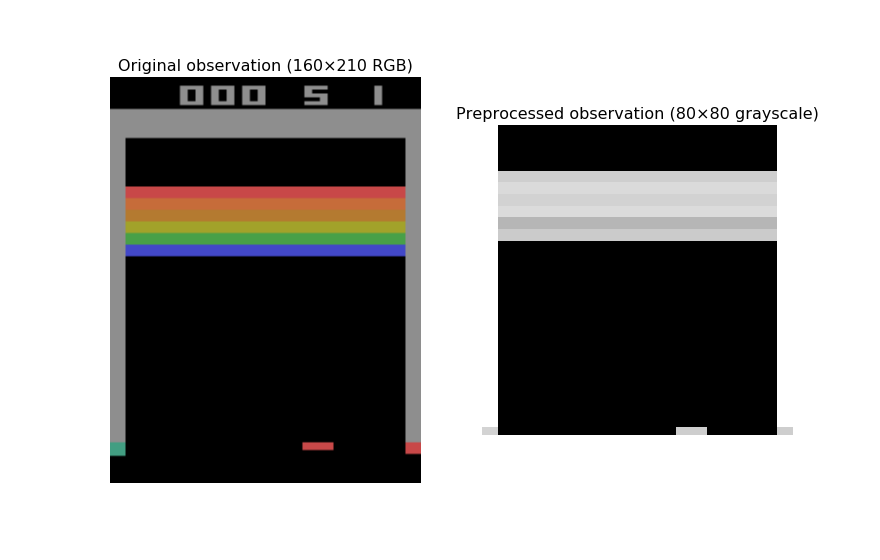

In [29]:



plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (80×80 grayscale)")
plt.imshow(img.reshape(80, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

As you can see, a single image does not give you the direction and speed of the ball, which are crucial informations for playing this game. For this reason, it is best to actually combine several consecutive observations to create the environment's state representation. One way to do that is to create a multi-channel image, with one channel per recent observation. Another is to merge all recent observations into a single-channel image, using `np.max()`. In this case, we need to dim the older images so that the DQN can distinguish the past from the present.

In [30]:
from collections import deque

def combine_observations_multichannel(preprocessed_observations):
    return np.array(preprocessed_observations).transpose([1,2,3, 0])
 
def combine_observations_singlechannel(preprocessed_observations, dim_factor=0.5):
    dimmed_observations = [obs * dim_factor**index
                           for index, obs in enumerate(reversed(preprocessed_observations))]
    return np.max(np.array(dimmed_observations), axis=0)

n_observations_per_state = 4
preprocessed_observations = deque([], maxlen=n_observations_per_state)

obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(step % 2)
    preprocessed_observations.append(preprocess_observation(obs))

<IPython.core.display.Javascript object>


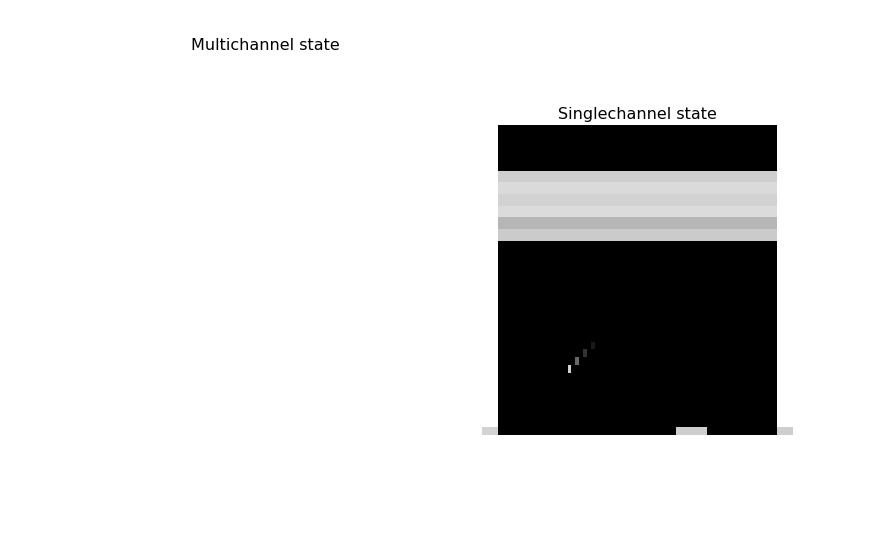

In [31]:
#img1 = combine_observations_multichannel(preprocessed_observations)
img2 = combine_observations_singlechannel(preprocessed_observations)


plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Multichannel state")
#plt.imshow(img1, interpolation="nearest")
plt.axis("off")
plt.subplot(122)
plt.title("Singlechannel state")
plt.imshow(img2.reshape(80, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
#img1.shape

In [32]:
img2.shape

(80, 80, 1)

## Build DQN

Note: instead of using `tf.contrib.layers.convolution2d()` or `tf.contrib.layers.conv2d()` (as in the first version of the book), we now use the `tf.layers.conv2d()`, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same, except that the parameter names have changed slightly:
* the `num_outputs` parameter was renamed to `filters`,
* the `stride` parameter was renamed to `strides`,
* the `_fn` suffix was removed from parameter names that had it (e.g., `activation_fn` was renamed to `activation`),
* the `weights_initializer` parameter was renamed to `kernel_initializer`,
* the weights variable was renamed to `"kernel"` (instead of `"weights"`), and the biases variable was renamed from `"biases"` to `"bias"`,
* and the default `activation` is now `None` instead of `tf.nn.relu`.

In [33]:
reset_graph()

input_height = 80
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
#n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden_in = 64 * 10 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 4 discrete actions are available
initializer = tf.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel intensities to the [-1.0, 1.0] range.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [34]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width
                                            ,input_channels
                                           ])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

In [35]:
online_vars

{'/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(6400, 512) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/online/dense_1/bias:0' shape=(4,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/de

In [36]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    
    game_num = tf.Variable(0, trainable=False, name='game_num')

    increment_game_num_op = tf.assign(game_num, game_num + 1)

    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Note: in the first version of the book, the loss function was simply the squared error between the target Q-Values (`y`) and the estimated Q-Values (`q_value`). However, because the experiences are very noisy, it is better to use a quadratic loss only for small errors (below 1.0) and a linear loss (twice the absolute error) for larger errors, which is what the code above computes. This way large errors don't push the model parameters around as much. Note that we also tweaked some hyperparameters (using a smaller learning rate, and using Nesterov Accelerated Gradients rather than Adam optimization, since adaptive gradient algorithms may sometimes be bad, according to this [paper](https://arxiv.org/abs/1705.08292)). We also tweaked a few other hyperparameters below (a larger replay memory, longer decay for the $\epsilon$-greedy policy, larger discount rate, less frequent copies of the online DQN to the target DQN, etc.).

We use this `ReplayMemory` class instead of a `deque` because it is much faster for random access (thanks to @NileshPS who contributed it). Moreover, we default to sampling with replacement, which is much faster than sampling without replacement for large replay memories.

In [37]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [38]:
replay_memory_size = 1000000
replay_memory = ReplayMemory(replay_memory_size)

In [39]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [143]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 5000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs),0,epsilon # random action
    else:
        return np.argmax(q_values),1, epsilon # optimal action

In [41]:
n_steps = 4000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 10 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 32
iteration = 0  # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset

A few variables for tracking progress:

In [42]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

total_game_length_ = 0
total_game_reward_ = 0

mean_game_length_ = 0
mean_game_reward_ = 0

max_game_length_ = 0
max_game_reward_ = 0

game_length = 0
game_reward = 0



And now the main training loop!

In [43]:
'''
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs_pacman"
logdir = "{}/run-{}/".format(root_logdir, now)

mean_game_reward_summary = tf.summary.scalar('Mean_Game_Reward', mean_game_reward)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
'''

'\nfrom datetime import datetime\nnow = datetime.utcnow().strftime("%Y%m%d%H%M%S")\nroot_logdir = "tf_logs_pacman"\nlogdir = "{}/run-{}/".format(root_logdir, now)\n\nmean_game_reward_summary = tf.summary.scalar(\'Mean_Game_Reward\', mean_game_reward)\n\nfile_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())\n'

In [44]:
n_observations_per_state = 4
preprocessed_observations = deque([], maxlen=n_observations_per_state)

In [45]:
game_actions_taken = {}
total_game_actions_taken = {}

In [46]:
game_rewards = {}

In [155]:
decision_ = 0
decisions_ = 0
epsilon = 0
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1

        print("\rIteration {}\tGame {}({},{:.0%},{:.0%},{},{:.1f},{})\tTraining step {}/{} ({:.1f})%\tGame Len {}/{:.1f}\tGame Reward {:.1f}/{:.4f}\tLoss {:.1f}\tMean Max-Q {:.1f}\tGame Actions {}\tTotal Actions{}\tGame Rewars{}\tQ-Values{},{},\tInfo {})   ".format(
                iteration, game_num, action,np.round(decisions_/(game_length+1),2),np.round(epsilon,2),game_length,game_reward,info['ale.lives'], step, n_steps, step * 100 / n_steps,max_game_length_,mean_game_length_,max_game_reward_,mean_game_reward_,loss_val, mean_max_q,game_actions_taken,total_game_actions_taken,game_rewards,q_values,np.argmax(q_values),info), end="")

        #game_new = False
        if done: # game over, start again
            obs = env.reset()
            game_num = sess.run(increment_game_num_op)
            #game_new = True
            
            #for skip in range(skip_start): # skip the start of each game
            #    obs, reward, done, info = env.step(0)
            #state = preprocess_observation(obs)
            #obs, reward, done, info = env.step(1)
                
            preprocessed_observations.append(preprocess_observation(obs))
            state = combine_observations_singlechannel(preprocessed_observations)
            game_actions_taken = {}

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        #action,decision_,epsilon = epsilon_greedy(q_values, step)
        action = np.argmax(q_values)
        decisions_ += decision_
        if action in game_actions_taken:
            game_actions_taken[action] += 1
        else:
            game_actions_taken[action] = 1
            
        if action in total_game_actions_taken:
            total_game_actions_taken[action] += 1
        else:
            total_game_actions_taken[action] = 1
        
        # Online DQN plays
        obs, reward, done, info = env.step(action)
        #next_state = preprocess_observation(obs)
        preprocessed_observations.append(preprocess_observation(obs))
        next_state = combine_observations_singlechannel(preprocessed_observations)

        # Let's memorize what happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Compute statistics for tracking progress (not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        game_reward += reward
        
        total_game_reward_ += reward
        total_game_length_ += 1

        
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0

            mean_game_reward_ = total_game_reward_ / game_num
            mean_game_length_ = total_game_length_ / game_num
            
            if game_length > max_game_length_:
                max_game_length_ = game_length
                
            if game_reward > max_game_reward_:
                max_game_reward_ = game_reward
            
                        
            if game_reward in game_rewards:
                game_rewards[game_reward] += 1
            else:
                game_rewards[game_reward] = 1
                
            game_length = 0
            game_reward = 0
            decisions_ = 0
            
        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals
        '''
        if iteration % training_interval == 0: #and game_new:
            #game_new = True
            # Sample memories and use the target DQN to produce the target Q-Value
            X_state_val, X_action_val, rewards, X_next_state_val, continues = (
                sample_memories(batch_size))
            next_q_values = target_q_values.eval(
                feed_dict={X_state: X_next_state_val})
            max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
            y_val = rewards + continues * discount_rate * max_next_q_values

            # Train the online DQN
            _, loss_val = sess.run([training_op, loss], feed_dict={
                X_state: X_state_val, X_action: X_action_val, y: y_val})
        '''
        
        # Regularly copy the online DQN to the target DQN
        if iteration % copy_steps == 0:
            copy_online_to_target.run()

        # And save regularly
        if iteration % save_steps == 0:
            saver.save(sess, checkpoint_path)

#file_writer.close()

Iteration 1681152	Game 7351(3,0%,0%,3616,7.0,1)	Training step 413287/4000000 (10.3)%	Game Len 851/228.2	Game Reward 14.0/2.5827	Loss 0.0	Mean Max-Q 0.9	Game Actions {0: 6, 1: 7, 2: 5, 3: 3599}	Total Actions{0: 327114, 1: 366315, 2: 322250, 3: 665466}	Game Rewars{0.0: 1632, 1.0: 1430, 2.0: 1581, 3.0: 1082, 4.0: 475, 5.0: 224, 6.0: 81, 7.0: 418, 8.0: 130, 9.0: 73, 10.0: 10, 11.0: 245, 12.0: 14, 13.0: 3, 14.0: 1}	Q-Values[[0.86800456 0.87021327 0.8671143  0.8758358 ]],3,	Info {'ale.lives': 1})   

KeyboardInterrupt: 

You can interrupt the cell above at any time to test your agent using the cell below. You can then run the cell above once again, it will load the last parameters saved and resume training.

In [151]:
n_observations_per_state = 4
preprocessed_observations_eval = deque([], maxlen=n_observations_per_state)

frames = []
n_max_steps = 100

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    obs, reward, done, info = env.step(0)
    obs, reward, done, info = env.step(0)
    obs, reward, done, info = env.step(3)
    obs, reward, done, info = env.step(3)
    obs, reward, done, info = env.step(3)
    for step_ in range(n_max_steps):
        
        #state = preprocess_observation(obs)
        preprocessed_observations_eval.append(preprocess_observation(obs))
        state = combine_observations_singlechannel(preprocessed_observations_eval)

        #plt.figure(figsize=(11, 7))
        #plt.subplot(121)
        #plt.title("Original observation (160×210 RGB)")
        #plt.imshow(obs)
        #plt.axis("off")
        #plt.subplot(122)
        #plt.title("Preprocessed observation (80×80 grayscale)")
        #plt.imshow(state.reshape(80, 80), interpolation="nearest", cmap="gray")
        #print(state.shape)
        #print(np.sum(state))
        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        print (q_values)
        action = np.argmax(q_values)
        print(action,end="")
        # Online DQN plays
        obs, reward, done, info = env.step(action)
        #obs, reward, done, info = env.step(env.action_space.sample())

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

[[0.8680911  0.87027633 0.86722285 0.8758961 ]]
3[[0.86809886 0.87029076 0.8672204  0.87590307]]
3[[0.868101   0.8702915  0.86721635 0.8759155 ]]
3[[0.8681022  0.87029153 0.8672144  0.8759178 ]]
3[[0.86810344 0.8702929  0.86721337 0.8759198 ]]
3[[0.8681036 0.8702922 0.8672129 0.8759202]]
3[[0.8681036 0.8702922 0.8672129 0.8759202]]
3[[0.8681036 0.8702922 0.8672129 0.8759202]]
3[[0.8681036 0.8702922 0.8672129 0.8759202]]
3[[0.8681036 0.8702922 0.8672129 0.8759202]]
3[[0.8681036 0.8702922 0.8672129 0.8759202]]
3[[0.8681036 0.8702922 0.8672129 0.8759202]]
3[[0.8681036 0.8702922 0.8672129 0.8759202]]
3[[0.8681036 0.8702922 0.8672129 0.8759202]]
3[[0.8681036 0.8702922 0.8672129 0.8759202]]
3[[0.8681036 0.8702922 0.8672129 0.8759202]]
3[[0.8681036 0.8702922 0.8672129 0.8759202]]
3[[0.8681036 0.8702922 0.8672129 0.8759202]]
3[[0.8681036 0.8702922 0.8672129 0.8759202]]
3[[0.8681036 0.8702922 0.8672129 0.8759202]]
3[[0.8681036 0.8702922 0.8672129 0.8759202]]
3[[0.8681036 0.8702922 0.8672129 0.8

<IPython.core.display.Javascript object>


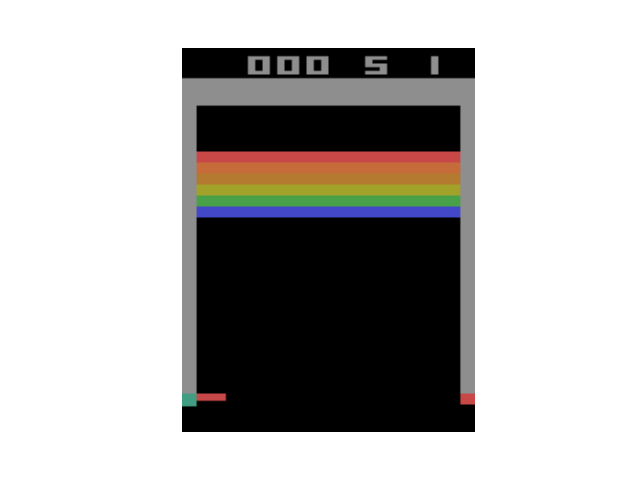

In [152]:
plot_animation(frames,name = "")